In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import os
import shutil

from pandas.plotting import register_matplotlib_converters


In [2]:
os.getcwd()

'C:\\Users\\zooondatch\\Documents\\code\\Pytorch_practie'

In [3]:
os.chdir('C:\\Users\zooondatch\Documents\code\Pytorch_practie\COVID-19\csse_covid_19_data\csse_covid_19_time_series')

In [4]:
os.listdir()

['.gitignore',
 'Errata.csv',
 'README.md',
 'time_series_covid19_confirmed_global.csv',
 'time_series_covid19_confirmed_US.csv',
 'time_series_covid19_deaths_global.csv',
 'time_series_covid19_deaths_US.csv',
 'time_series_covid19_recovered_global.csv']

In [20]:
df = pd.read_csv('time_series_covid19_confirmed_global.csv')

In [21]:
df

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,4/26/20,4/27/20,4/28/20,4/29/20,4/30/20,5/1/20,5/2/20,5/3/20,5/4/20,5/5/20
0,NaN,Afghanistan,33.000000,65.000000,0,0,0,0,0,0,...,1531,1703,1828,1939,2171,2335,2469,2704,2894,3224
1,NaN,Albania,41.153300,20.168300,0,0,0,0,0,0,...,726,736,750,766,773,782,789,795,803,820
2,NaN,Algeria,28.033900,1.659600,0,0,0,0,0,0,...,3382,3517,3649,3848,4006,4154,4295,4474,4648,4838
3,NaN,Andorra,42.506300,1.521800,0,0,0,0,0,0,...,738,743,743,743,745,745,747,748,750,751
4,NaN,Angola,-11.202700,17.873900,0,0,0,0,0,0,...,26,27,27,27,27,30,35,35,35,36
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
261,NaN,Western Sahara,24.215500,-12.885800,0,0,0,0,0,0,...,6,6,6,6,6,6,6,6,6,6
262,NaN,Sao Tome and Principe,0.186360,6.613081,0,0,0,0,0,0,...,4,4,8,8,14,16,16,16,23,174
263,NaN,Yemen,15.552727,48.516388,0,0,0,0,0,0,...,1,1,1,6,6,7,10,10,12,22
264,NaN,Comoros,-11.645500,43.333300,0,0,0,0,0,0,...,0,0,0,0,1,1,3,3,3,3


In [217]:
df_japan = df.loc[df['Country/Region'] == 'Japan']

df_japan = df_japan.iloc[0, 43:]
df_japan

3/1/20      256
3/2/20      274
3/3/20      293
3/4/20      331
3/5/20      360
          ...  
5/1/20    14305
5/2/20    14571
5/3/20    14877
5/4/20    15078
5/5/20    15253
Name: 139, Length: 66, dtype: object

In [218]:
df_japan.index = pd.to_datetime(df_japan.index)
df_japan

2020-03-01      256
2020-03-02      274
2020-03-03      293
2020-03-04      331
2020-03-05      360
              ...  
2020-05-01    14305
2020-05-02    14571
2020-05-03    14877
2020-05-04    15078
2020-05-05    15253
Name: 139, Length: 66, dtype: object

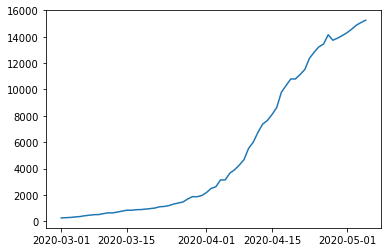

In [219]:
plt.plot(df_japan)

In [335]:
y = df_japan.values.astype(float)

In [336]:
test_size = 3
train_original_data = y[:-test_size]
test_original_data = y[-test_size:]

In [337]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(-1,1))

In [338]:
train_normalized = scaler.fit_transform(train_original_data.reshape(-1,1))
train_normalized.shape

(63, 1)

In [393]:
train_normalized = torch.FloatTensor(train_normalized).view(-1)
window_size = 5

In [394]:
def sequence_creator(input_data, window):
    dataset = []
    data_len = len(input_data)
    for i in range(data_len - window):
        window_fr = input_data[i:i+window]
        label = input_data[i+window:i+window+1]
        dataset.append((window_fr, label))
    return dataset

In [395]:
train_data = sequence_creator(train_normalized, window_size)

In [396]:
class LSTM_Corona(nn.Module):
    def __init__(self, in_size=1, h_size=30, out_size=1):
        super().__init__()
        self.h_size = h_size
        self.lstm = nn.LSTM(in_size, h_size)
        self.fc = nn.Linear(h_size, out_size)
        
        self.hidden = (torch.zeros(1,1,h_size),torch.zeros(1,1,h_size))
        
    def forward(self, sequence_data):
        lstm_out, self.hidden = self.lstm(sequence_data.view(len(sequence_data),1,-1), self.hidden)
        pred = self.fc(lstm_out.view(len(sequence_data), -1))
        
        return pred[-1]

In [397]:
torch.manual_seed(1)
model = LSTM_Corona()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [398]:
model.train()

epochs = 100

for epoch in range(epochs):
    for sequence_in, y_train in train_data:
        y_pred = model(sequence_in)
        loss = criterion(y_pred, y_train)
        
        optimizer.zero_grad()
        model.hidden = (torch.zeros(1,1,model.h_size),torch.zeros(1,1,model.h_size))
        
        loss.backward()
        optimizer.step()
    
    print(f'Epoch {epoch+1} Loss {loss.item(): .3f}')

Epoch 1 Loss  0.933
Epoch 2 Loss  0.520
Epoch 3 Loss  0.074
Epoch 4 Loss  0.009
Epoch 5 Loss  0.002
Epoch 6 Loss  0.004
Epoch 7 Loss  0.001
Epoch 8 Loss  0.003
Epoch 9 Loss  0.001
Epoch 10 Loss  0.002
Epoch 11 Loss  0.001
Epoch 12 Loss  0.001
Epoch 13 Loss  0.001
Epoch 14 Loss  0.001
Epoch 15 Loss  0.001
Epoch 16 Loss  0.001
Epoch 17 Loss  0.001
Epoch 18 Loss  0.001
Epoch 19 Loss  0.001
Epoch 20 Loss  0.001
Epoch 21 Loss  0.001
Epoch 22 Loss  0.001
Epoch 23 Loss  0.001
Epoch 24 Loss  0.001
Epoch 25 Loss  0.001
Epoch 26 Loss  0.001
Epoch 27 Loss  0.000
Epoch 28 Loss  0.000
Epoch 29 Loss  0.000
Epoch 30 Loss  0.000
Epoch 31 Loss  0.000
Epoch 32 Loss  0.000
Epoch 33 Loss  0.000
Epoch 34 Loss  0.000
Epoch 35 Loss  0.000
Epoch 36 Loss  0.000
Epoch 37 Loss  0.000
Epoch 38 Loss  0.000
Epoch 39 Loss  0.000
Epoch 40 Loss  0.000
Epoch 41 Loss  0.000
Epoch 42 Loss  0.000
Epoch 43 Loss  0.000
Epoch 44 Loss  0.000
Epoch 45 Loss  0.000
Epoch 46 Loss  0.000
Epoch 47 Loss  0.000
Epoch 48 Loss  0.000
E

In [399]:
test = 3

preds = train_normalized[-window_size:].tolist()

model.eval()

for i in range(test):
    sequence = torch.FloatTensor(preds[-window_size:])
    with torch.no_grad():
        model.hidden = (torch.zeros(1,1,model.h_size), torch.zeros(1,1,model.h_size))
        preds.append(model(sequence).item())

In [400]:
predictions = scaler.inverse_transform(np.array(preds[window_size:]).reshape(-1,1))

In [401]:
predictions

array([[15310.91787034],
       [15418.84535861],
       [15515.04499882]])

In [402]:
df_japan = pd.DataFrame(df_japan)

In [403]:
# x = np.arange('2020-05-03', '2020-05-06', dtype='datetime64[D]').astype('datetime64[D]')
x = np.arange('2020-05-03','2020-05-06', dtype='datetime64[D]').astype('datetime64[D]')

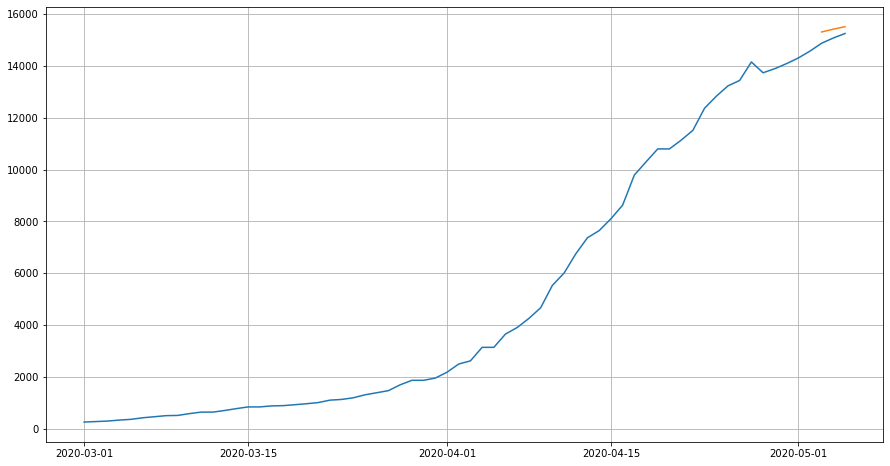

In [404]:
plt.figure(figsize=(15,8))
plt.grid(True)
plt.plot(df_japan)
plt.plot(x, predictions)
plt.show()

In [405]:
epochs = 200
model.train()

y_normalized = scaler.fit_transform(y.reshape(-1,1))
y_normalized = torch.FloatTensor(y_normalized).view(-1)
full_data = sequence_creator(y_normalized, window_size)

In [406]:
for epoch in range(epochs):
    for sequence_in, y_train in full_data:
        y_pred = model(sequence_in)
        loss = criterion(y_pred, y_train)
        
        optimizer.zero_grad()
        model.hidden = (torch.zeros(1,1,model.h_size), torch.zeros(1,1,model.h_size))
        
        loss.backward()
        optimizer.step()
        
    print(f'Epoch {epoch+1} Loss {loss.item():.5f}')

Epoch 1 Loss 0.00044
Epoch 2 Loss 0.00223
Epoch 3 Loss 0.00406
Epoch 4 Loss 0.00459
Epoch 5 Loss 0.00444
Epoch 6 Loss 0.00395
Epoch 7 Loss 0.00346
Epoch 8 Loss 0.00310
Epoch 9 Loss 0.00293
Epoch 10 Loss 0.00288
Epoch 11 Loss 0.00286
Epoch 12 Loss 0.00283
Epoch 13 Loss 0.00281
Epoch 14 Loss 0.00281
Epoch 15 Loss 0.00281
Epoch 16 Loss 0.00281
Epoch 17 Loss 0.00280
Epoch 18 Loss 0.00278
Epoch 19 Loss 0.00276
Epoch 20 Loss 0.00274
Epoch 21 Loss 0.00271
Epoch 22 Loss 0.00269
Epoch 23 Loss 0.00266
Epoch 24 Loss 0.00264
Epoch 25 Loss 0.00261
Epoch 26 Loss 0.00259
Epoch 27 Loss 0.00256
Epoch 28 Loss 0.00253
Epoch 29 Loss 0.00251
Epoch 30 Loss 0.00249
Epoch 31 Loss 0.00246
Epoch 32 Loss 0.00244
Epoch 33 Loss 0.00242
Epoch 34 Loss 0.00239
Epoch 35 Loss 0.00237
Epoch 36 Loss 0.00235
Epoch 37 Loss 0.00232
Epoch 38 Loss 0.00230
Epoch 39 Loss 0.00228
Epoch 40 Loss 0.00226
Epoch 41 Loss 0.00224
Epoch 42 Loss 0.00222
Epoch 43 Loss 0.00221
Epoch 44 Loss 0.00219
Epoch 45 Loss 0.00218
Epoch 46 Loss 0.002

In [407]:
future = 10

preds = y_normalized[-window_size:].tolist()

model.eval()

for i in range(future):
    sequence = torch.FloatTensor(preds[-window_size:])
    
    with torch.no_grad():
        model.hidden = (torch.zeros(1,1,model.h_size),torch.zeros(1,1,model.h_size))
        preds.append(model(sequence).item())
        
predictions = scaler.inverse_transform(np.array(preds).reshape(-1,1))


x = np.arange('2020-05-07', '2020-05-17', dtype='datetime64[D]').astype('datetime64[D]')

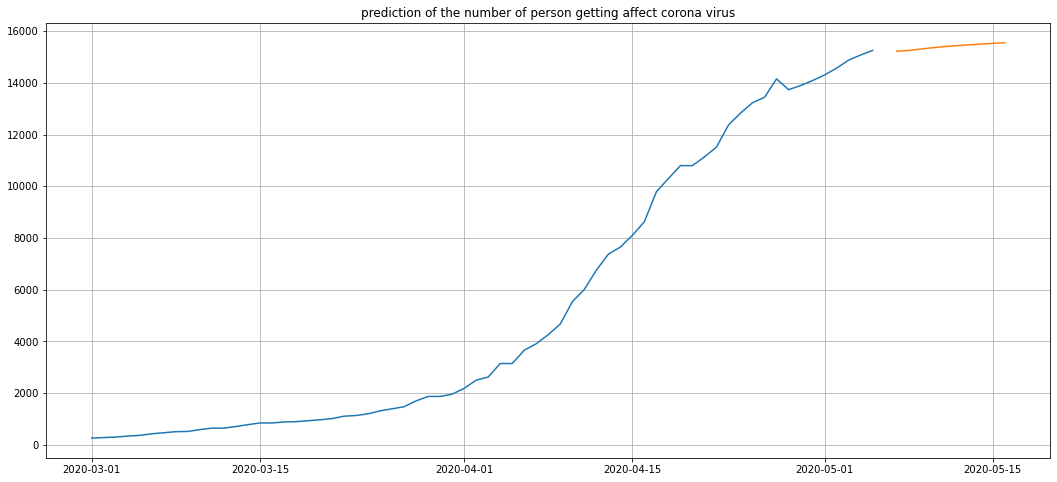

In [408]:
plt.figure(figsize=(18, 8))

plt.title('prediction of the number of person getting affect corona virus')
plt.grid(True)
plt.plot(df_japan)
plt.plot(x,predictions[window_size:])